In [15]:
DRIVER_LS = {1:0,4:0,807:0,815:1,817:1,822:0,825:1,830:0,832:1,839:1,840:1,842:0,844:0,846:0,847:1,848:0,852:0,855:1,857:1,858:1,860:2,861:2}
DRIVER_C = {1:"#00CACA",4:"#2E8B57",807:"#191919",815:"#0000B0",817:"#7B68EE",822:"#00FF00",825:"#191919",830:"#0000B0",832:"#FF0000",839:"#FF69B4",840:"#2E8B57",842:"#FF69B4",844:"#FF0000",846:"#FE7F00",847:"#00CACA",848:"#007FFE",852:"#7B68EE",855:"#00FF00",857:"#FE7F00",858:"#007FFE",860:"#FF0000",861:"#007FFE"}
TEAM_C = {1:"#FE7F00",3:"#007FFE",6:"#FF0000",9:"#0000B0",15:"#00FF00",117:"#2E8B57",131:"#00CACA",210:"#191919",214:"#FF69B4",215:"#7B68EE"}
LINESTYLES = ['-', '-.', '--', ':', '-', '-']


from IPython.display import HTML, display
HTML("""<div id="contents"></div>
<script>
function fill_toc() {
  l = document.querySelectorAll("h2[id^=race]")
  src = '<h2 id="index-races">Races</h2>'
  for (const e of l) src += `<li><a href="#${e.id}">${e.textContent}</a>`;
  document.querySelector("#contents").innerHTML = src;
}
</script>""")

In [16]:
import base64, io, json, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from collections import Counter


def read_csv(name, **kwargs):
    df = pd.read_csv(f'data/{name}', na_values=r'\N', **kwargs)
    return df


# create replacement raceId that is ordered by time
def race_key(race_year, race_round):
    # My bet: we won't get to 100 races per year :)
    return (race_year * 100) + race_round

def races_subset(df, race_ids):
    df = df[df.raceId.isin(race_ids)].copy()
    df = df.join(races[['round', 'raceKey']], on='raceId')
    df['round'] -= df['round'].min()
    # drop_duplicates: duplicate entries have appeared in 2021
    # race:1051 driver:832
    return df.set_index('round').sort_index().drop_duplicates()

def add_lap_0(df):
    copy = df.T
    copy.insert(0, 0, 0)
    return copy.T

def driver_tag(driver_df_row):
    return ('<a href="{url}" title="Number: {number:.0f}\n'
            'Nationality: {nationality}">{Driver}</a>').format(**driver_df_row)

def constructor_tag(constructor_df_row):
    return ('<a href="{url}" title="Nationality: {nationality}">'
            '{name}</a>').format(**constructor_df_row)



RACE_COLS = ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url']


YEAR = 2024
# Read data
circuits = read_csv('circuits.csv', index_col=0)
constructorResults = read_csv('constructor_results.csv', index_col=0)
constructors = read_csv('constructors.csv', index_col=0)
constructorStandings = read_csv('constructor_standings.csv', index_col=0)
drivers = read_csv('drivers.csv', index_col=0)
driverStandings = read_csv('driver_standings.csv', index_col=0)
lapTimes = read_csv('lap_times.csv')
pitStops = read_csv('pit_stops.csv')
qualifying = read_csv('qualifying.csv', index_col=0)
races = read_csv('races.csv', index_col='raceId', usecols=RACE_COLS)
results = read_csv('results.csv', index_col=0)
seasons = read_csv('seasons.csv', index_col=0)
status = read_csv('status.csv', index_col=0)


# To sequence the races if they did not happen in order of raceId (ie. 2021)
races['raceKey'] = race_key(races['year'], races['round'])

# For display in HTML tables
drivers['display'] = drivers.surname
drivers['Driver'] = drivers['forename'] + " " + drivers['surname']
drivers['Driver'] = drivers.apply(driver_tag, axis=1)
constructors['label'] = constructors['name']
constructors['name'] = constructors.apply(constructor_tag, axis=1)

# Join fields
results['status'] = results.statusId.map(status.status)
results['Team'] = results.constructorId.map(constructors.name)
results['score'] = results.points>0
results['podium'] = results.position<=3

# Cut data to one year
# was using numexpr here but 2.8.5 breaks pandas:
# https://github.com/pandas-dev/pandas/issues/54449
races = races.loc[races.year==YEAR].sort_values('round').copy()
results = results[results.raceId.isin(races.index)].copy()
lapTimes = lapTimes[lapTimes.raceId.isin(races.index)].copy()
# Save Ids of races that have actually happened (i.e. have valid lap-times).
race_ids = np.unique(lapTimes.raceId)
driverStandings = races_subset(driverStandings, race_ids)
constructorStandings = races_subset(constructorStandings, race_ids)

# Sprint results (2021 onwards)
if os.path.isfile('../input/formula-1-race-data/sprint_results.csv'):
    sprint_results = pd.read_csv('../input/formula-1-race-data/sprint_results.csv', na_values=r'\N')
    sprint_results = sprint_results[sprint_results.raceId.isin(races.index)].copy()

lapTimes = lapTimes.merge(results[['raceId', 'driverId', 'positionOrder']], on=['raceId', 'driverId'])
lapTimes['seconds'] = lapTimes.pop('milliseconds') / 1000

def formatter(v):
    if type(v) is str:
        return v
    if pd.isna(v) or v <= 0:
        return ''
    if v == int(v):
        return f'{v:.0f}'
    return f'{v:.1f}'

def table_html(table, caption):
    return (f'<h3>{caption}</h3>' +
            table.style.format(formatter).to_html())

# Processing for Drivers & Constructors championship tables
def format_standings(df, key):
    df = df.sort_values('position')
    gb = results.groupby(key)
    df['Position'] = df.positionText
    df['scores'] = gb.score.sum()
    df['podiums'] = gb.podium.sum()
    return df

# Drivers championship table
def drivers_standings(df):
    index = 'driverId'
    df = df.set_index(index)
    df = df.join(drivers)
    df = format_standings(df, index)
    df['Team'] = results.groupby(index).Team.last()
    use = ['Position', 'Driver',  'Team', 'points', 'wins', 'podiums', 'scores', 'nationality' ]
    df = df[use].set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Constructors championship table
def constructors_standings(df):
    index = 'constructorId'
    df = df.set_index(index)
    df = df.join(constructors)
    df = format_standings(df, index)
    
    # add drivers for team
    tmp = results.join(drivers.drop(labels="number", axis=1), on='driverId')
    df = df.join(tmp.groupby(index).Driver.unique().str.join(', ').to_frame('Drivers'))

    use = ['Position', 'name', 'points', 'wins', 'podiums', 'scores', 'nationality', 'Drivers' ]
    df = df[use].set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Race results table
def format_results(df):
    df['Team'] = df.constructorId.map(constructors.name)
    df['Position'] = df.positionOrder
    use = ['Driver', 'Team', 'grid', 'Position', 'points', 'laps', 'time', 'status' ]
    df = df[use].sort_values('Position')
    df = df.set_index('Position')
    df.columns = df.columns.str.capitalize()
    return df

# Return the HTML img tag for a plot - allows us to set an alt tag for the image
# Added for accessibility and to fix warning:
# [NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
def render_plot(title, alt_txt):
    fig = plt.gcf()
    fig.set_facecolor('white')
    buf = io.BytesIO()
    metadata = {'Title': title,
                'Author': 'James Trotman',
                'Source': f'https://www.kaggle.com/code/jtrotman/f1-race-traces-{YEAR}'}
    fig.savefig(buf, format='png', bbox_inches='tight', metadata=metadata)
    plt.close()
    b64 = base64.b64encode(buf.getvalue()).decode()
    return '<img alt="%s" src="data:image/png;base64,%s">' % (alt_txt, b64)

In [17]:
results

,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,...,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,status,Team,score,podium
resultId,,,,,,,,,,,,,,,,,,,,,
26286,1121,830,9,1.0,1,1.0,1,1,26.0,57,...,5504742.0,39.0,1.0,1:32.608,210.383,1,Finished,"<a href=""http://en.wikipedia.org/wiki/Red_Bull...",True,True
26287,1121,815,9,11.0,5,2.0,2,2,18.0,57,...,5527199.0,40.0,4.0,1:34.364,206.468,1,Finished,"<a href=""http://en.wikipedia.org/wiki/Red_Bull...",True,True
26288,1121,832,6,55.0,4,3.0,3,3,15.0,57,...,5529852.0,44.0,6.0,1:34.507,206.156,1,Finished,"<a href=""http://en.wikipedia.org/wiki/Scuderia...",True,True
26289,1121,844,6,16.0,2,4.0,4,4,12.0,57,...,5544411.0,36.0,2.0,1:34.090,207.069,1,Finished,"<a href=""http://en.wikipedia.org/wiki/Scuderia...",True,False
26290,1121,847,131,63.0,3,5.0,5,5,10.0,57,...,5551530.0,40.0,12.0,1:35.065,204.946,1,Finished,"<a href=""http://en.wikipedia.org/wiki/Mercedes...",True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26600,1136,822,15,77.0,19,16.0,16,16,0.0,52,...,NaN,52.0,13.0,1:23.609,249.432,11,+1 Lap,"<a href=""http://en.wikipedia.org/wiki/Sauber_M...",False,False
26601,1136,807,210,27.0,10,17.0,17,17,0.0,52,...,NaN,44.0,11.0,1:23.275,250.432,11,+1 Lap,"<a href=""http://en.wikipedia.org/wiki/Haas_F1_...",False,False
26602,1136,855,15,24.0,20,18.0,18,18,0.0,52,...,NaN,17.0,19.0,1:25.092,245.085,11,+1 Lap,"<a href=""http://en.wikipedia.org/wiki/Sauber_M...",False,False


,Driver,Team,Points,Wins,Podiums,Scores,Nationality
Position,,,,,,,
1,Max Verstappen,Red Bull,303,7,10,15,Dutch
2,Lando Norris,McLaren,241,2,10,15,British
3,Charles Leclerc,Ferrari,217,2,8,13,Monegasque
4,Oscar Piastri,McLaren,197,1,5,15,Australian
5,Carlos Sainz,Ferrari,184,1,5,14,Spanish
6,Lewis Hamilton,Mercedes,164,2,4,15,British
7,Sergio Pérez,Red Bull,143,,4,13,Mexican
8,George Russell,Mercedes,128,1,2,13,British
9,Fernando Alonso,Aston Martin,50,,,10,Spanish

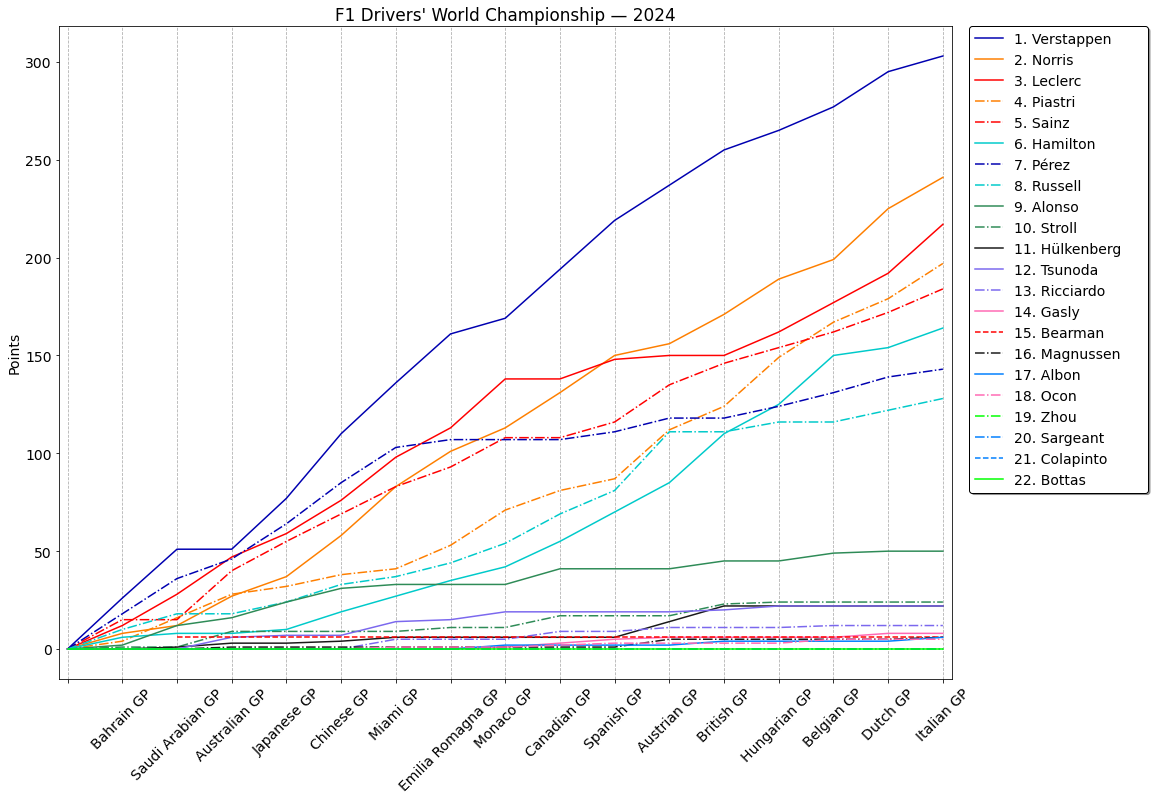

In [18]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=(14))
plt.rc("axes", xmargin=0.01)

# Championship position traces
champ = driverStandings.groupby("driverId").position.last().to_frame("Pos")
champ = champ.join(drivers)
order = np.argsort(champ.Pos)

color = [DRIVER_C[d] for d in champ.index[order]]
style = [LINESTYLES[DRIVER_LS[d]] for d in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.display

chart = driverStandings.pivot(index="raceKey", columns="driverId", values="points")
names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))

chart.iloc[:, order].plot(title=f"F1 Drivers\' World Championship — {YEAR}", color=color, style=style)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
legend_opts = dict(bbox_to_anchor=(1.02, 0, 0.2, 1),
                   loc="upper right",
                   ncol=1,
                   shadow=True,
                   edgecolor="black",
                   mode="expand",
                   borderaxespad=0.)
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Drivers\' World Championship &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Drivers\' World Championship - {YEAR}',
                f'Formula One Drivers\' World Championship - {YEAR}'),
    table_html(drivers_standings(driverStandings.loc[driverStandings.index.max()]), "Results")
]
HTML("\n".join(html_lines))

,Name,Points,Wins,Podiums,Scores,Nationality,Drivers
Position,,,,,,,
1,Red Bull,446,7,14,28,Austrian,"Max Verstappen, Sergio Pérez"
2,McLaren,438,3,15,30,British,"Lando Norris, Oscar Piastri"
3,Ferrari,407,3,13,28,Italian,"Carlos Sainz, Charles Leclerc, Oliver Bearman"
4,Mercedes,292,3,6,28,German,"George Russell, Lewis Hamilton"
5,Aston Martin,74,,,16,British,"Fernando Alonso, Lance Stroll"
6,RB F1 Team,34,,,10,Italian,"Daniel Ricciardo, Yuki Tsunoda"
7,Haas F1 Team,28,,,8,American,"Kevin Magnussen, Nico Hülkenberg"
8,Alpine F1 Team,13,,,9,French,"Esteban Ocon, Pierre Gasly"
9,Williams,6,,,3,British,"Alexander Albon, Logan Sargeant, Franco Colapinto"

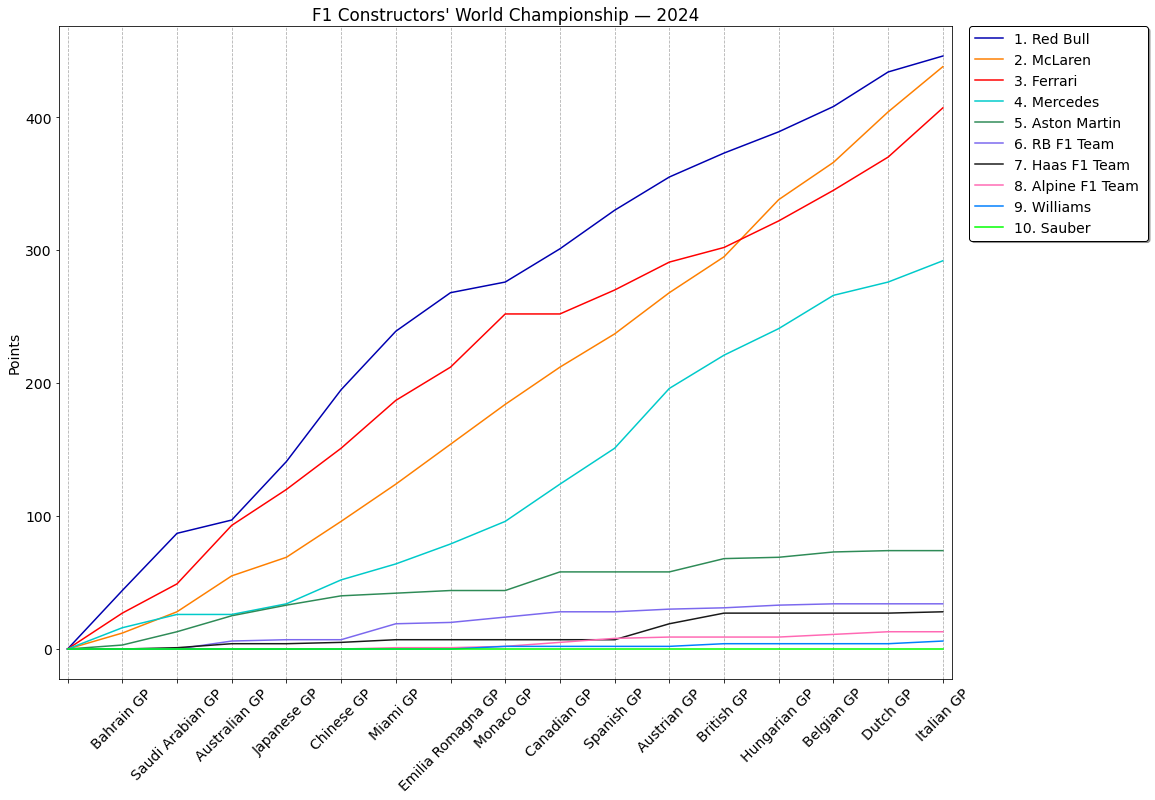

In [19]:
# Championship position traces
champ = constructorStandings.groupby("constructorId").position.last().to_frame("Pos")
champ = champ.join(constructors)
order = np.argsort(champ.Pos)

color = [TEAM_C[c] for c in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.label

chart = constructorStandings.pivot(index="raceKey", columns="constructorId", values="points")
names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))

chart.iloc[:, order].plot(title=f"F1 Constructors\' World Championship — {YEAR}", color=color)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Constructors\' World Championship &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Constructors\' World Championship - {YEAR}',
                f'Formula One Constructors\' World Championship - {YEAR}'),
    table_html(constructors_standings(constructorStandings.loc[constructorStandings.index.max()]), "Results")
]
HTML("\n".join(html_lines))

In [34]:
chart.diff().fillna(0).rolling(axis=0,window=5,min_periods=1).mean()

,2. McLaren,9. Williams,3. Ferrari,1. Red Bull,10. Sauber,5. Aston Martin,4. Mercedes,7. Haas F1 Team,8. Alpine F1 Team,6. RB F1 Team
,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
Bahrain GP,6.000000,0.0,13.500000,22.00,0.0,1.500000,8.000000,0.000000,0.0,0.0
Saudi Arabian GP,9.333333,0.0,16.333333,29.00,0.0,4.333333,8.666667,0.333333,0.0,0.0
Australian GP,13.750000,0.0,23.250000,24.25,0.0,6.250000,6.500000,1.000000,0.0,1.5
Japanese GP,13.800000,0.0,24.000000,28.20,0.0,6.600000,6.800000,0.800000,0.0,1.4
Chinese GP,19.200000,0.0,30.200000,39.00,0.0,8.000000,10.400000,1.000000,0.0,1.4
Miami GP,22.400000,0.0,32.000000,39.00,0.0,7.800000,9.600000,1.400000,0.2,3.8
Emilia Romagna GP,25.200000,0.0,32.600000,36.20,0.0,6.200000,10.600000,1.200000,0.2,4.0
Monaco GP,25.800000,0.4,31.800000,35.80,0.0,3.800000,14.000000,0.600000,0.4,3.6
Canadian GP,28.600000,0.4,26.400000,32.00,0.0,5.000000,18.000000,0.600000,1.0,4.2



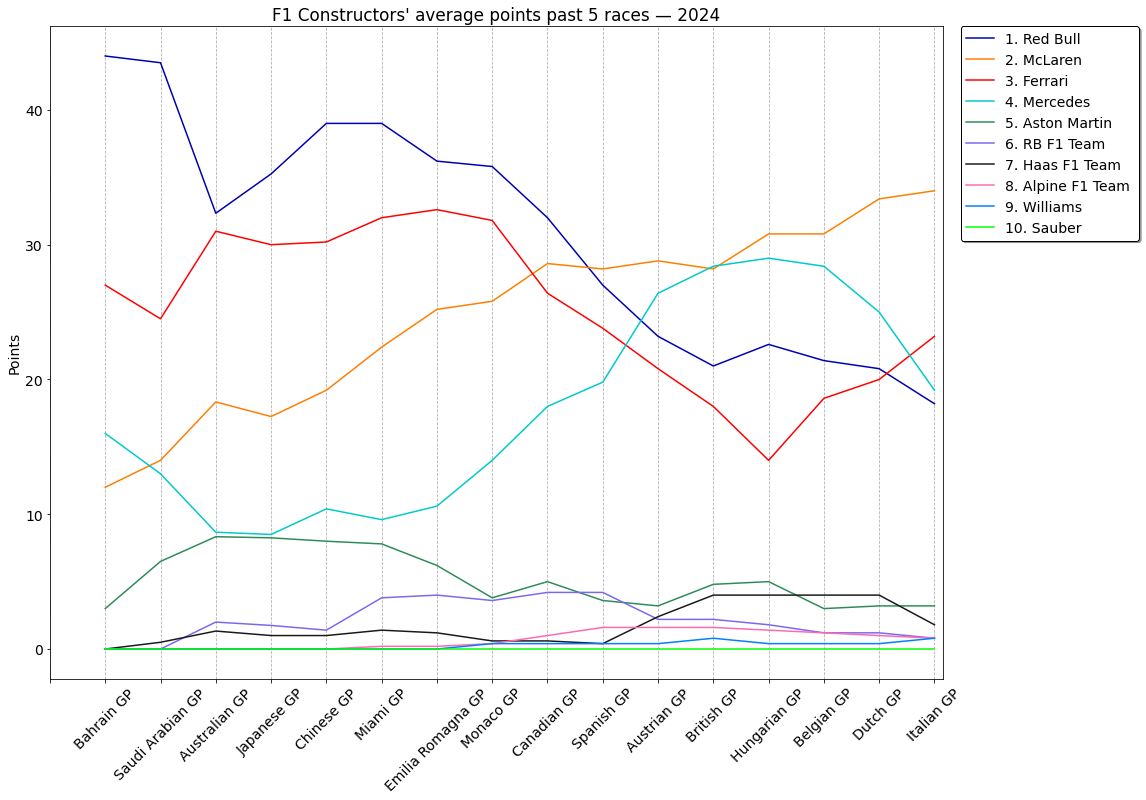

In [48]:
# Championship position traces
champ = constructorStandings.groupby("constructorId").position.last().to_frame("Pos")
champ = champ.join(constructors)
order = np.argsort(champ.Pos)

color = [TEAM_C[c] for c in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.label

chart = constructorStandings.pivot(index="raceKey", columns="constructorId", values="points")

names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))
chart = chart.diff().rolling(axis=0,window=5,min_periods=1).mean()
chart.iloc[:, order].plot(title=f"F1 Constructors\' average points past 5 races — {YEAR}", color=color)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Constructors\' Rolling mean past 5 races &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Constructors\' rolling mean - {YEAR}',
                f'Formula One Constructors\' rolling mean - {YEAR}'),
   
]
HTML("\n".join(html_lines))


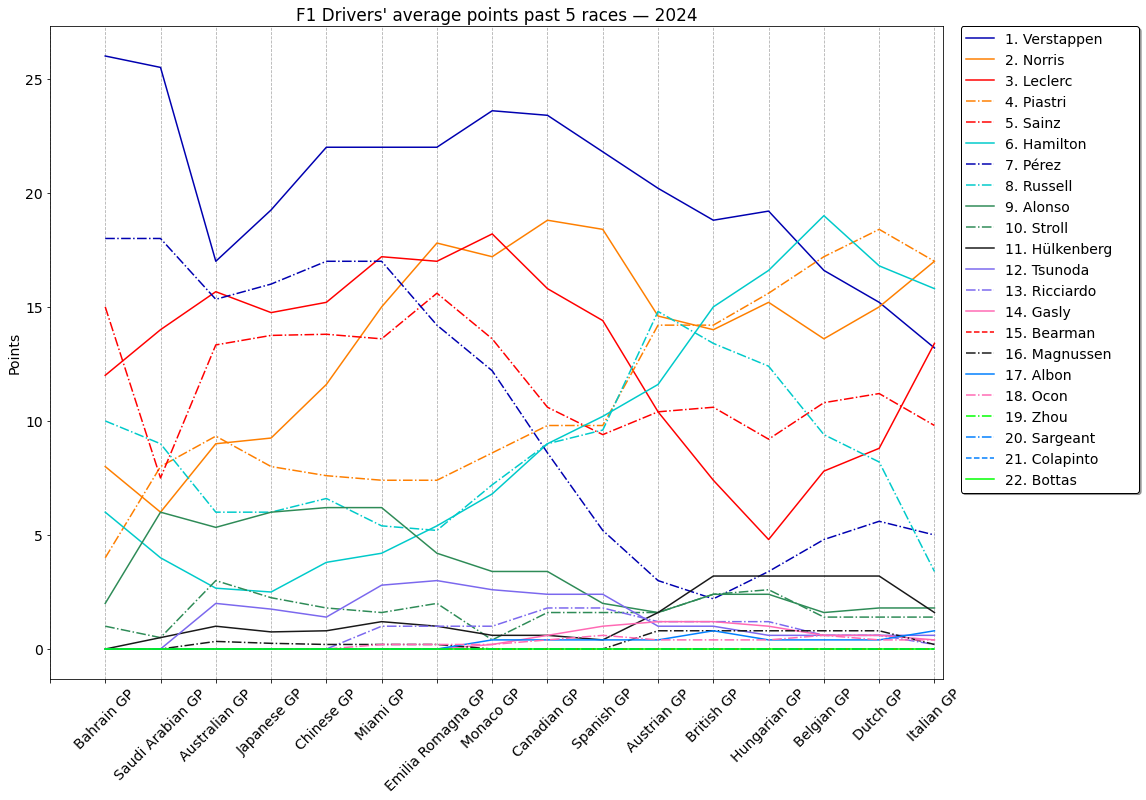

In [52]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=(14))
plt.rc("axes", xmargin=0.01)

# Championship position traces
champ = driverStandings.groupby("driverId").position.last().to_frame("Pos")
champ = champ.join(drivers)
order = np.argsort(champ.Pos)

color = [DRIVER_C[d] for d in champ.index[order]]
style = [LINESTYLES[DRIVER_LS[d]] for d in champ.index[order]]
labels = champ.Pos.astype(str) + ". " + champ.display

chart = driverStandings.pivot(index="raceKey", columns="driverId", values="points")

names = races.set_index("raceKey").reindex(chart.index).name
names = names.str.replace("Grand Prix", "GP").rename("Race")
chart.index = names
chart.columns = labels

# Add origin
row = chart.iloc[0]
chart = pd.concat(((row * 0).to_frame("").T, chart))
chart = chart.diff().rolling(axis=0,window=5,min_periods=1).mean()
chart.iloc[:, order].plot(title=f"F1 Drivers\' average points past 5 races — {YEAR}", color=color, style=style)
plt.xticks(range(chart.shape[0]), chart.index, rotation=45)
plt.grid(axis="x", linestyle="--")
plt.ylabel("Points")
legend_opts = dict(bbox_to_anchor=(1.02, 0, 0.2, 1),
                   loc="upper right",
                   ncol=1,
                   shadow=True,
                   edgecolor="black",
                   mode="expand",
                   borderaxespad=0.)
plt.legend(**legend_opts)

html_lines = [
    f'<h2 id="drivers">Formula One Drivers\' World Championship &mdash; {YEAR}</h2>',
    render_plot(f'Formula One Drivers\' World Championship - {YEAR}',
                f'Formula One Drivers\' World Championship - {YEAR}'),
]
HTML("\n".join(html_lines))

In [51]:
chart

,6. Hamilton,9. Alonso,11. Hülkenberg,7. Pérez,13. Ricciardo,22. Bottas,16. Magnussen,1. Verstappen,5. Sainz,18. Ocon,...,3. Leclerc,2. Norris,8. Russell,17. Albon,12. Tsunoda,19. Zhou,4. Piastri,20. Sargeant,15. Bearman,21. Colapinto
,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bahrain GP,6.000000,2.000000,0.00,18.000000,0.0,0.0,0.000000,26.00,15.000000,0.0,...,12.000000,8.00,10.0,0.0,0.00,0.0,4.000000,0.0,NaN,NaN
Saudi Arabian GP,4.000000,6.000000,0.50,18.000000,0.0,0.0,0.000000,25.50,7.500000,0.0,...,14.000000,6.00,9.0,0.0,0.00,0.0,8.000000,0.0,NaN,NaN
Australian GP,2.666667,5.333333,1.00,15.333333,0.0,0.0,0.333333,17.00,13.333333,0.0,...,15.666667,9.00,6.0,0.0,2.00,0.0,9.333333,0.0,0.0,NaN
Japanese GP,2.500000,6.000000,0.75,16.000000,0.0,0.0,0.250000,19.25,13.750000,0.0,...,14.750000,9.25,6.0,0.0,1.75,0.0,8.000000,0.0,0.0,NaN
Chinese GP,3.800000,6.200000,0.80,17.000000,0.0,0.0,0.200000,22.00,13.800000,0.0,...,15.200000,11.60,6.6,0.0,1.40,0.0,7.600000,0.0,0.0,NaN
Miami GP,4.200000,6.200000,1.20,17.000000,1.0,0.0,0.200000,22.00,13.600000,0.2,...,17.200000,15.00,5.4,0.0,2.80,0.0,7.400000,0.0,0.0,NaN
Emilia Romagna GP,5.400000,4.200000,1.00,14.200000,1.0,0.0,0.200000,22.00,15.600000,0.2,...,17.000000,17.80,5.2,0.0,3.00,0.0,7.400000,0.0,0.0,NaN
Monaco GP,6.800000,3.400000,0.60,12.200000,1.0,0.0,0.000000,23.60,13.600000,0.2,...,18.200000,17.20,7.2,0.4,2.60,0.0,8.600000,0.0,0.0,NaN
Canadian GP,9.000000,3.400000,0.60,8.600000,1.8,0.0,0.000000,23.40,10.600000,0.4,...,15.800000,18.80,9.0,0.4,2.40,0.0,9.800000,0.0,0.0,NaN
